In [2]:
from pathlib import Path
import pandas as pd


In [4]:
filename = Path('./data/processed/20210818_evening_toilet_visits.csv')
df = pd.read_csv(filename)

df


,guest_or_staff,start_time,end_time,visit_time
0,G,2021-08-18 17:19:14,2021-08-18 17:21:22,128.0
1,G,2021-08-18 17:20:21,2021-08-18 17:22:52,151.0
2,G,2021-08-18 17:20:28,2021-08-18 17:22:06,98.0
3,G,2021-08-18 17:23:24,2021-08-18 17:25:04,100.0
4,G,2021-08-18 17:26:27,2021-08-18 17:27:40,73.0
...,...,...,...,...
111,G,2021-08-18 21:41:54,2021-08-18 21:42:41,47.0
112,G,2021-08-18 21:48:39,2021-08-18 21:50:04,85.0
113,G,2021-08-18 21:50:22,2021-08-18 21:52:45,143.0
114,G,2021-08-18 21:51:33,2021-08-18 21:53:36,123.0


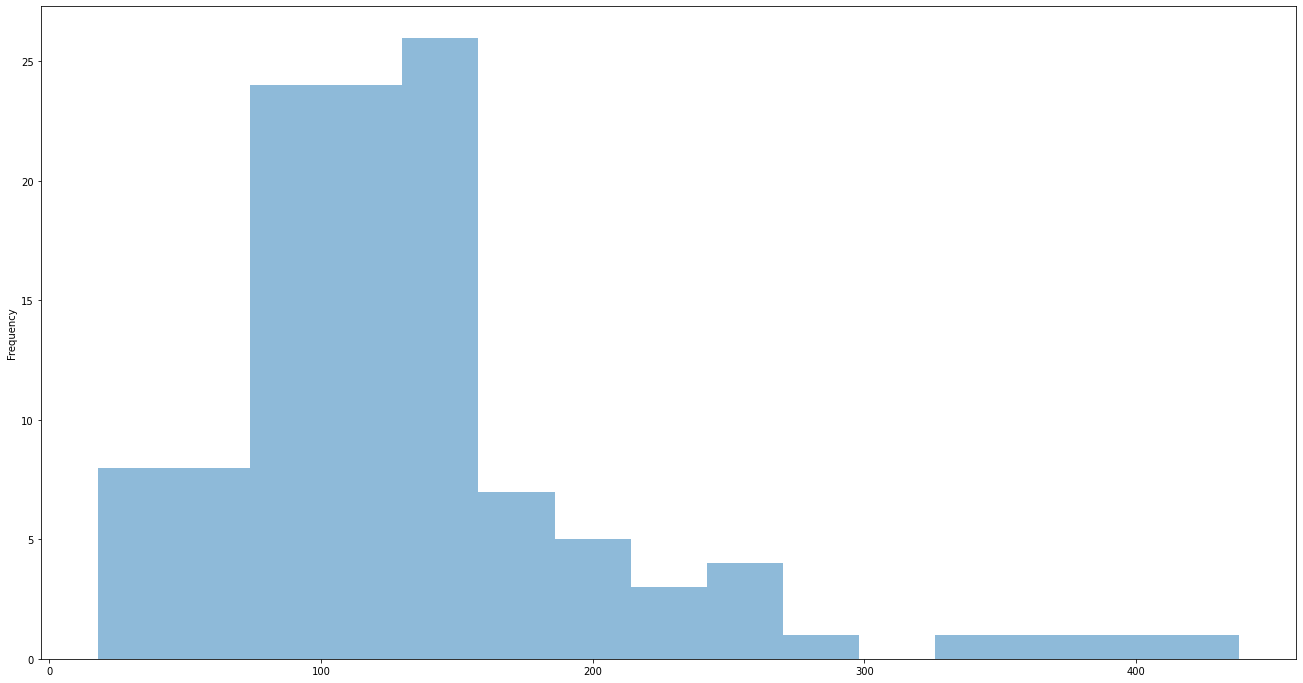

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [22.5,12]

visit_times = df['visit_time'][df['visit_time'].notnull()]
ax = visit_times.plot.hist(bins=15, alpha=0.5)



In [38]:
%%capture --no-stdout
from scipy import stats

list_of_dists = [nm for nm, _ in stats._distr_params.distdiscrete]

results = []

for i in list_of_dists:
    dist = getattr(stats, i)
    try:
        param = dist.fit(visit_times)
        a = stats.kstest(visit_times, i, args=param)
    except:
        print(f'Could not fit {i}')
        continue
    results.append((i,a[0],a[1], param))
        
results.sort(key=lambda x:float(x[2]), reverse=True)
    

Could not fit bernoulli
Could not fit betabinom
Could not fit binom
Could not fit boltzmann
Could not fit dlaplace
Could not fit geom
Could not fit hypergeom
Could not fit hypergeom
Could not fit hypergeom
Could not fit nchypergeom_fisher
Could not fit nchypergeom_wallenius
Could not fit logser
Could not fit nbinom
Could not fit nbinom
Could not fit planck
Could not fit poisson
Could not fit randint
Could not fit skellam
Could not fit zipf
Could not fit zipfian
Could not fit zipfian
Could not fit yulesimon
Could not fit nhypergeom


In [ ]:
for j in results:
    print("{}: statistic={}, pvalue={}".format(j[0], j[1], j[2]))
    
with open(Path('./data/stats/toilet_fits_discrete.txt'), 'w') as f:
    f.write('#name, statistic, pvalue, params\n')
    for j in results:
        f.write(f'{j[0]}, {j[1]:.4f}, {j[2]:.4f}, {j[3]}\n')

In [32]:
import numpy as np

y,x = np.histogram(visit_times, bins=20, density=True)
print(x)
print(y)

[ 18.  39.  60.  81. 102. 123. 144. 165. 186. 207. 228. 249. 270. 291.
 312. 333. 354. 375. 396. 417. 438.]
[0.00250627 0.00125313 0.00501253 0.00793651 0.00710109 0.00793651
 0.00710109 0.00167084 0.00208855 0.00041771 0.00167084 0.00083542
 0.00041771 0.         0.00041771 0.         0.00041771 0.00041771
 0.         0.00041771]


In [37]:
from scipy import stats

print(stats._distr_params.__dict__.keys())


dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__cached__', '__builtins__', 'np', 'distcont', 'distdiscrete', 'invdistdiscrete', 'invdistcont'])


In [8]:
import ast
import numpy as np
import scipy.stats as stats

def process_line(line):
    line = line.strip()
    start_ind = 0
    parts = []
    for ii in range(3):
        comma_index = line.find(',', start_ind)
        value = line[start_ind:comma_index].strip()
        if ii == 1 or ii == 2:
            value = float(value)        
        start_ind = comma_index + 1
        parts.append(value)
        
    parts.append(ast.literal_eval(line[start_ind:].strip()))
    return parts

with open(Path('./data/stats/toilet_fits.txt'), 'r') as f:
    lines = [process_line(line) for line in f if '#' not in line]

min_value = min(visit_times)
max_value = max(visit_times)    
    
distrs = []
name_length_max = 0
for ii, distr_data in enumerate(lines):
    res = stats.cramervonmises(visit_times, distr_data[0], args=distr_data[3])
    dist = getattr(stats, distr_data[0])(*distr_data[3])
    x = np.arange(max(min_value, dist.ppf(x_per_lim)), min(max_value,dist.ppf(1-x_per_lim)), 1)
    distrs.append((distr_data[0], distr_data[2], res.pvalue, distr_data[3]))
    if len(distr_data[0]) > name_length_max:
        name_length_max = len(distr_data[0])

distrs.sort(key=lambda el: el[2], reverse=True)        
    
for name, ks_p_value, cvm_p_value, params in distrs:    
    print(f'{name:>{name_length_max}s} - {ks_p_value:.4f} - {cvm_p_value:.4f} - {len(params)}')
    

C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\scipy\stats\_continuous_distns.py:3094: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  t1 = integrate.quad(llc, -np.inf, x)[0]
C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\scipy\stats\_continuous_distns.py:3099: RuntimeWarning: Infinite values encountered in scipy.special.kve. Values replaced by NaN to avoid incorrect results.
  warnings.warn(msg, RuntimeWarning)
C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\numpy\lib\function_base.py:2246: RuntimeWarning: invalid value encountered in _ppf_single (vectorized)
  outputs = ufunc(*inputs)
C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-inte

         johnsonsu - 0.8872 - 0.9565 - 4
       levy_stable - 0.7579 - 0.8746 - 4
laplace_asymmetric - 0.7200 - 0.8345 - 3
              fisk - 0.6755 - 0.8234 - 3
              burr - 0.5674 - 0.7632 - 4
            mielke - 0.5509 - 0.7510 - 4
           laplace - 0.6855 - 0.6889 - 2
          dweibull - 0.6518 - 0.6885 - 3
           gennorm - 0.6667 - 0.6737 - 3
         exponnorm - 0.4968 - 0.6707 - 3
        skewcauchy - 0.8486 - 0.6685 - 3
               nct - 0.5192 - 0.6293 - 4
            burr12 - 0.4539 - 0.6251 - 4
         hypsecant - 0.6735 - 0.6140 - 2
        loglaplace - 0.5711 - 0.6024 - 3
            dgamma - 0.5488 - 0.6010 - 3
        foldcauchy - 0.6697 - 0.5908 - 3
       genlogistic - 0.3391 - 0.4798 - 3
          gumbel_r - 0.3177 - 0.4250 - 2
        genextreme - 0.3433 - 0.4182 - 3
        invweibull - 0.3485 - 0.4038 - 3
          logistic - 0.4717 - 0.3956 - 2
         exponweib - 0.3134 - 0.3941 - 4
          invgamma - 0.3413 - 0.3937 - 3
      norminvgau

C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\scipy\stats\_continuous_distns.py:108: RuntimeWarning: floating point number truncated to an integer
  return scu._smirnovc(n, x)
C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\scipy\stats\_continuous_distns.py:114: RuntimeWarning: floating point number truncated to an integer
  return scu._smirnovci(n, q)


C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\scipy\stats\_continuous_distns.py:3094: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  t1 = integrate.quad(llc, -np.inf, x)[0]
C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\scipy\stats\_continuous_distns.py:3099: RuntimeWarning: Infinite values encountered in scipy.special.kve. Values replaced by NaN to avoid incorrect results.
  warnings.warn(msg, RuntimeWarning)
C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\numpy\lib\function_base.py:2246: RuntimeWarning: invalid value encountered in _ppf_single (vectorized)
  outputs = ufunc(*inputs)
C:\Users\martijnsparnaa\Anaconda3\envs\nomad_experiments\lib\site-packages\scipy\stats\_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-inte

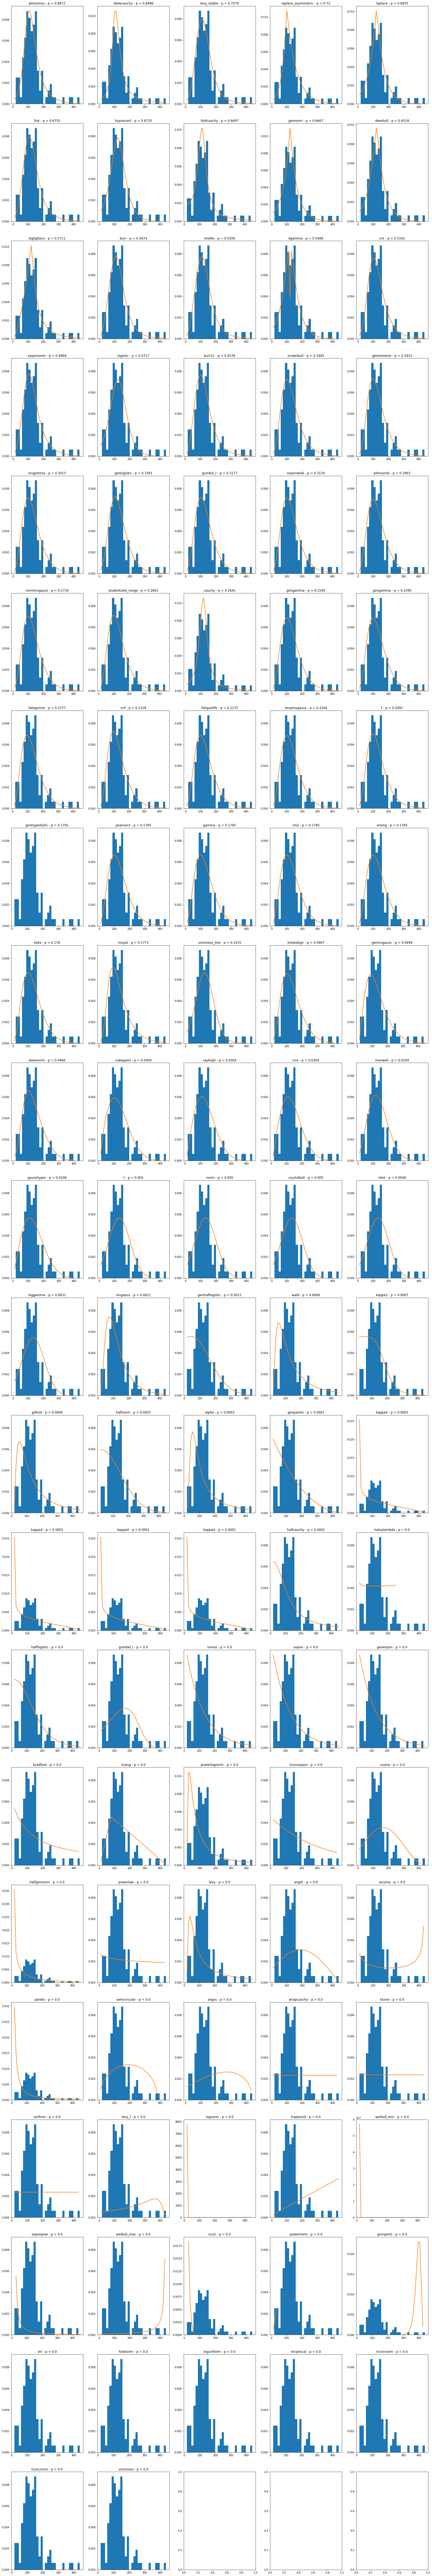

In [10]:
import ast
import numpy as np

def process_line(line):
    line = line.strip()
    start_ind = 0
    parts = []
    for ii in range(3):
        comma_index = line.find(',', start_ind)
        value = line[start_ind:comma_index].strip()
        if ii == 1 or ii == 2:
            value = float(value)        
        start_ind = comma_index + 1
        parts.append(value)
        
    parts.append(ast.literal_eval(line[start_ind:].strip()))
    return parts

with open(Path('./data/stats/toilet_fits.txt'), 'r') as f:
    lines = [process_line(line) for line in f if '#' not in line]

#lines = lines[:5]

import matplotlib.pyplot as plt
from math import ceil

plt.rcParams['figure.figsize'] = [28.5,180]

col_count = 5
row_count = int(ceil(len(lines)/col_count))
_, axes = plt.subplots(row_count, col_count)

axes = axes.flatten()

import scipy.stats as stats

min_value = min(visit_times)
max_value = max(visit_times)
diff_value = max_value - min_value

#min_value -= diff_value*0.1
#max_value += diff_value*0.1

min_value = 10
max_value = 450

x_per_lim = 0.001

for ii, distr_data in enumerate(lines):
    hist = axes[ii].hist(visit_times, bins=30, density=True)
    dist = getattr(stats, distr_data[0])(*distr_data[3])
    x = np.arange(max(min_value, dist.ppf(x_per_lim)), min(max_value,dist.ppf(1-x_per_lim)), 10)
    axes[ii].plot(x, dist.pdf(x), linewidth=2)
    axes[ii].set_title(f'{distr_data[0]} - p = {distr_data[2]}')
    
   

## Activity times

In [ ]:
filename = Path('./data/processed/20210818_evening_staff_activities.csv')
df = pd.read_csv(filename, parse_dates=['start_time', 'end_time'])

df

In [ ]:
import numpy as np

activitiy_times = np.array((df['end_time'] - df['start_time'])/np.timedelta64(1, 's'))

In [ ]:
import matplotlib.pyplot as plt
hist = plt.hist(activitiy_times, bins=15)
print(np.mean(activitiy_times))

In [ ]:
%%capture --no-stdout
from scipy import stats

list_of_dists = [nm for nm, _ in stats._distr_params.distcont]

results = []

for i in list_of_dists:
    dist = getattr(stats, i)
    try:
        param = dist.fit(activitiy_times)
        a = stats.kstest(activitiy_times, i, args=param)
    except:
        print(f'Could not fit {i}')
        continue
    results.append((i,a[0],a[1], param))
        
results.sort(key=lambda x:float(x[2]), reverse=True)

In [ ]:
for j in results:
    print("{}: statistic={}, pvalue={}".format(j[0], j[1], j[2]))
    
with open(Path('./data/stats/activitiy_time_fits.txt'), 'w') as f:
    f.write('name, statistic, pvalue, params\n')
    for j in results:
        f.write(f'{j[0]}, {j[1]:.4f}, {j[2]:.4f}, {j[3]}\n')